In [ ]:
%pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 69.5 MB/s eta 0:00:00


In [ ]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST, Flowers102

import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torchmetrics.image.fid import FrechetInceptionDistance
from tqdm import tqdm


random_seed = 42
torch.manual_seed(random_seed)

# Optimize for Tensor Cores (A100 GPU) - improves performance
torch.set_float32_matmul_precision('medium')

BATCH_SIZE=64
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

In [ ]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [ ]:
class FlowersDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data",
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, image_size=64,
                 combine_train_val=True, use_augmentation=True):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.image_size = image_size
        self.combine_train_val = combine_train_val
        self.use_augmentation = use_augmentation

        # Base transform (always applied)
        base_transform = [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            # normalize to [-1, 1] for GANs
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]

        # Training transform with augmentation
        if use_augmentation:
            self.train_transform = transforms.Compose([
                transforms.Resize(int(image_size * 1.1)),  # Slightly larger for random crop
                transforms.RandomCrop(image_size),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
        else:
            self.train_transform = transforms.Compose(base_transform)

        # Validation/test transform (no augmentation)
        self.val_transform = transforms.Compose(base_transform)

    def prepare_data(self):
        Flowers102(self.data_dir, split="train", download=True)
        Flowers102(self.data_dir, split="val", download=True)
        Flowers102(self.data_dir, split="test", download=True)

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            flowers_train = Flowers102(self.data_dir, split="train",
                                       transform=self.train_transform)

            if self.combine_train_val:
                # Combine train and val splits for more training data
                flowers_val = Flowers102(self.data_dir, split="val",
                                         transform=self.train_transform)
                # Combine datasets
                from torch.utils.data import ConcatDataset
                self.flowers_train = ConcatDataset([flowers_train, flowers_val])
                print(f"Combined train+val: {len(self.flowers_train)} images")
                print(f"Batches per epoch: {len(self.flowers_train) // self.batch_size}")
            else:
                self.flowers_train = flowers_train
                self.flowers_val = Flowers102(self.data_dir, split="val",
                                              transform=self.val_transform)
                print(f"Train images: {len(self.flowers_train)}")
                print(f"Batches per epoch: {len(self.flowers_train) // self.batch_size}")

        if stage == "test" or stage is None:
            self.flowers_test = Flowers102(self.data_dir, split="test",
                                           transform=self.val_transform)

    def train_dataloader(self):
        return DataLoader(self.flowers_train, batch_size=self.batch_size,
                          num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return None

    def test_dataloader(self):
        if not hasattr(self, 'flowers_test'):
            self.setup(stage="test")
        return DataLoader(self.flowers_test, batch_size=self.batch_size,
                          num_workers=self.num_workers)

In [ ]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self, channels=1, image_size=28):
        super().__init__()
        self.channels = channels
        self.image_size = image_size

        if image_size == 64:
            # Stronger discriminator for 64x64 images
            # No batch norm on first layer (common practice)
            self.conv1 = nn.Conv2d(channels, 64, kernel_size=4, stride=2, padding=1)  # 64->32
            self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # 32->16
            self.bn2 = nn.BatchNorm2d(128)
            self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)  # 16->8
            self.bn3 = nn.BatchNorm2d(256)
            self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)  # 8->4
            self.bn4 = nn.BatchNorm2d(512)
            self.fc = nn.Linear(4 * 4 * 512, 1)
        else:  # 28x28
            # Calculate flattened size after conv layers
            flattened_size = 4 * 4 * 20
            self.conv1 = nn.Conv2d(channels, 10, kernel_size=5)
            self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
            self.conv2_drop = nn.Dropout2d()
            self.fc1 = nn.Linear(flattened_size, 50)
            self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        if self.image_size == 64:
            x = F.leaky_relu(self.conv1(x), 0.2)  # 32x32 (no batch norm on first layer)
            x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)  # 16x16
            x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)  # 8x8
            x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)  # 4x4
            x = x.view(x.size(0), -1)
            x = self.fc(x)
        else:  # 28x28
            x = F.relu(F.max_pool2d(self.conv1(x), 2))
            x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            x = F.dropout(x, training=self.training)
            x = self.fc2(x)

        return torch.sigmoid(x)

In [ ]:
# Generate Fake Data: output like real data
class Generator(nn.Module):
    def __init__(self, latent_dim, channels=1, image_size=28):
        super().__init__()
        self.image_size = image_size

        if image_size == 64:
            # For 64x64: start with 4x4, upsample to 8x8, 16x16, 32x32, 64x64
            self.lin1 = nn.Linear(latent_dim, 4*4*512)
            self.ct1 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1)  # 4->8
            self.bn1 = nn.BatchNorm2d(256)
            self.ct2 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)  # 8->16
            self.bn2 = nn.BatchNorm2d(128)
            self.ct3 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)   # 16->32
            self.bn3 = nn.BatchNorm2d(64)
            self.ct4 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)    # 32->64
            self.bn4 = nn.BatchNorm2d(32)
            self.conv = nn.Conv2d(32, channels, kernel_size=3, padding=1)    # 64->64
        else:  # 28x28
            self.lin1 = nn.Linear(latent_dim, 7*7*64)
            self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2)  # 7->14
            self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2)  # 14->28
            self.ct3 = None
            self.ct4 = None
            self.conv = nn.Conv2d(16, channels, kernel_size=7)  # 28->28

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)

        if self.image_size == 64:
            x = x.view(-1, 512, 4, 4)
            x = F.relu(self.bn1(self.ct1(x)))  # 8x8
            x = F.relu(self.bn2(self.ct2(x)))  # 16x16
            x = F.relu(self.bn3(self.ct3(x)))  # 32x32
            x = F.relu(self.bn4(self.ct4(x)))  # 64x64
            x = torch.tanh(self.conv(x))  # Output in [-1, 1] range
        else:  # 28x28
            x = x.view(-1, 64, 7, 7)
            x = F.relu(self.ct1(x))  # 14x14
            x = F.relu(self.ct2(x))  # 28x28
            x = torch.tanh(self.conv(x))  # Output in [-1, 1] range

        return x

In [ ]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, channels=1, image_size=28, lr=0.0002, label_smooth=0.1):
        super().__init__()
        self.save_hyperparameters()

        # Required for multiple optimizers
        self.automatic_optimization = False

        self.generator = Generator(latent_dim=latent_dim, channels=channels, image_size=image_size)
        self.discriminator = Discriminator(channels=channels, image_size=image_size)

        self.validation_z = torch.randn(8, self.hparams.latent_dim)
        self.total_epochs_trained = 0

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights for better training stability"""
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                nn.init.normal_(m.weight, 0.0, 0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx):
        opt_g, opt_d = self.optimizers()

        real_imgs, _ = batch
        batch_size = real_imgs.size(0)

        # Sample noise for generator
        z = torch.randn(batch_size, self.hparams.latent_dim)
        z = z.type_as(real_imgs)

        # Train Discriminator - but only if it's not too strong
        # Skip discriminator training if it's winning too easily (d_loss too low)
        opt_d.zero_grad()

        # Real images
        y_hat_real = self.discriminator(real_imgs)
        # Label smoothing: use 0.9 instead of 1.0 for real labels
        y_real = torch.ones(batch_size, 1) * (1.0 - self.hparams.label_smooth)
        y_real = y_real.type_as(real_imgs)
        real_loss = self.adversarial_loss(y_hat_real, y_real)

        # Fake images
        fake_imgs = self(z).detach()  # Detach to avoid training generator here
        y_hat_fake = self.discriminator(fake_imgs)
        # Add label smoothing to fake labels too (0.1 instead of 0.0)
        y_fake = torch.zeros(batch_size, 1) + self.hparams.label_smooth
        y_fake = y_fake.type_as(real_imgs)
        fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

        d_loss = (real_loss + fake_loss) / 2

        # Only train discriminator if it's not too strong (d_loss < 0.6)
        # This prevents discriminator from becoming too powerful
        if d_loss.item() < 0.6:
            # Discriminator is winning too easily, skip its training this step
            pass
        else:
            self.manual_backward(d_loss)
            opt_d.step()

        # Train Generator - always train, sometimes twice if discriminator is too strong
        opt_g.zero_grad()
        # Generate new fake images
        fake_imgs = self(z)
        y_hat = self.discriminator(fake_imgs)
        # Generator wants discriminator to think these are real
        y = torch.ones(batch_size, 1)
        y = y.type_as(real_imgs)
        g_loss = self.adversarial_loss(y_hat, y)

        self.manual_backward(g_loss)
        opt_g.step()

        # If discriminator is too strong, train generator again
        if d_loss.item() < 0.4:
            opt_g.zero_grad()
            z2 = torch.randn(batch_size, self.hparams.latent_dim)
            z2 = z2.type_as(real_imgs)
            fake_imgs2 = self(z2)
            y_hat2 = self.discriminator(fake_imgs2)
            y2 = torch.ones(batch_size, 1)
            y2 = y2.type_as(real_imgs)
            g_loss2 = self.adversarial_loss(y_hat2, y2)
            self.manual_backward(g_loss2)
            opt_g.step()
            g_loss = (g_loss + g_loss2) / 2

        # Log metrics using self.log() for ModelCheckpoint to monitor
        self.log('g_loss', g_loss, prog_bar=True)
        self.log('d_loss', d_loss, prog_bar=True)
        self.log('total_loss', g_loss + d_loss)

        return {'loss': g_loss + d_loss}


    def configure_optimizers(self):
        # Give generator higher learning rate to help it catch up
        lr_g = self.hparams.lr * 2.0  # 0.0004 - generator needs more help
        lr_d = self.hparams.lr * 0.5  # 0.0001 - slower discriminator
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
        return [opt_g, opt_d], []

    def on_train_epoch_end(self):
        e = self.total_epochs_trained
        is_power_of_2 = (e > 0 and (e & (e - 1)) == 0)
        show = (e < 200 and is_power_of_2) or e % 200 == 0
        self.plot_imgs(show=show)
        self.total_epochs_trained += 1

    def plot_imgs(self, show=True):
        if not show:
            return

        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()

        # Denormalize from [-1, 1] to [0, 1] for display
        sample_imgs = (sample_imgs + 1) / 2.0
        sample_imgs = torch.clamp(sample_imgs, 0, 1)

        fig = plt.figure(facecolor='black')
        fig.patch.set_facecolor('black')
        image_size = self.hparams.image_size
        channels = self.hparams.channels

        for i in range(sample_imgs.shape[0]):
            ax = plt.subplot(2, 4, i+1)
            ax.set_facecolor('black')
            plt.tight_layout()

            if channels == 1:
                # Grayscale image
                plt.imshow(sample_imgs.detach()[i, 0, :, :].reshape(image_size, image_size),
                          cmap='gray', interpolation='none')
            else:
                # RGB image - transpose from CHW to HWC
                img = sample_imgs.detach()[i].permute(1, 2, 0).numpy()
                plt.imshow(img, interpolation='none')

            plt.title('Epoch {}'.format(self.total_epochs_trained), color='white')
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')

        plt.show()
        plt.close(fig)

In [ ]:
# dm = MNISTDataModule()
# model = GAN()

dm = FlowersDataModule()
model = GAN(channels=3, image_size=64)

In [ ]:
# Standalone function to compute FID for a trained model using torchmetrics
def compute_fid_score(model, dataloader, n_samples=5000, device='cuda'):
    """
    Compute FID score for a trained GAN model using torchmetrics.

    Args:
        model: Trained GAN model
        dataloader: DataLoader with real images
        n_samples: Number of samples to use for FID calculation
        device: Device to run computation on

    Returns:
        FID score
    """
    fid_metric = FrechetInceptionDistance(normalize=True).to(device)

    model.eval()
    model = model.to(device)

    real_count = 0
    fake_count = 0

    print("Computing FID...")
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Processing"):
            if isinstance(batch, (list, tuple)):
                real_batch = batch[0]
            else:
                real_batch = batch

            real_batch = real_batch.to(device)

            # Generate fake images
            z = torch.randn(real_batch.shape[0], model.hparams.latent_dim, device=device)
            fake_batch = model(z)

            # Convert from [-1, 1] to [0, 255] uint8
            real_normalized = (real_batch + 1) / 2.0
            fake_normalized = (fake_batch + 1) / 2.0

            real_uint8 = (real_normalized.clamp(0, 1) * 255).byte()
            fake_uint8 = (fake_normalized.clamp(0, 1) * 255).byte()

            # Handle grayscale images
            if model.hparams.channels == 1:
                real_uint8 = real_uint8.repeat(1, 3, 1, 1)
                fake_uint8 = fake_uint8.repeat(1, 3, 1, 1)

            # Update metric
            fid_metric.update(real_uint8, real=True)
            fid_metric.update(fake_uint8, real=False)

            real_count += real_batch.shape[0]
            fake_count += fake_batch.shape[0]

            if real_count >= n_samples and fake_count >= n_samples:
                break

    # Compute FID score
    fid_score = fid_metric.compute().item()

    return fid_score


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
100%|██████████| 345M/345M [00:19<00:00, 17.6MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.85MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 38.6MB/s]


Combined train+val: 2040 images
Batches per epoch: 31


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ generator     │ Generator     │  3.6 M │ train │     0 │
│ 1 │ discriminator │ Discriminator │  2.8 M │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 6.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.4 M                                                                                                
Total estimated model params size (MB): 25                                                                         
Modules in train mode: 20                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:317: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


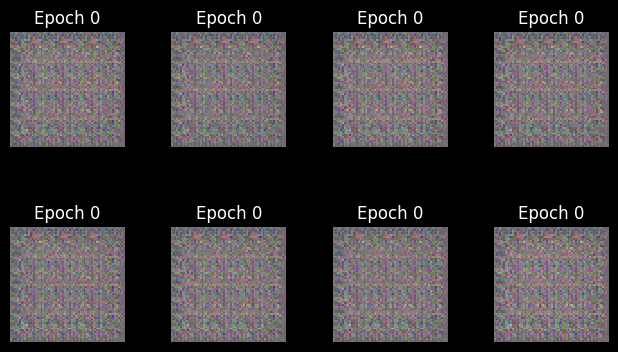

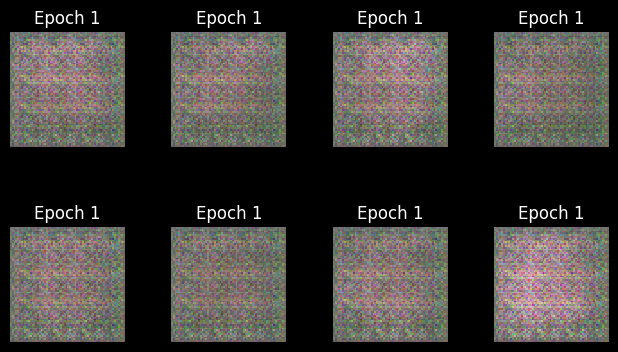

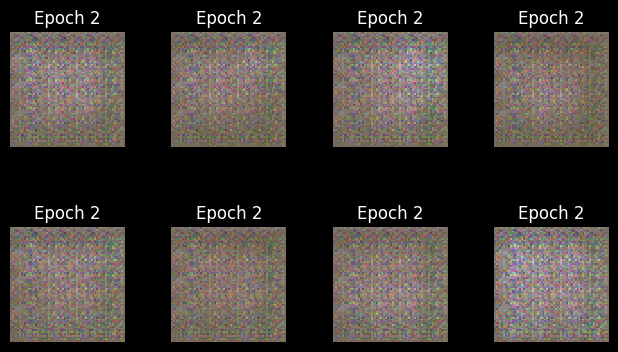

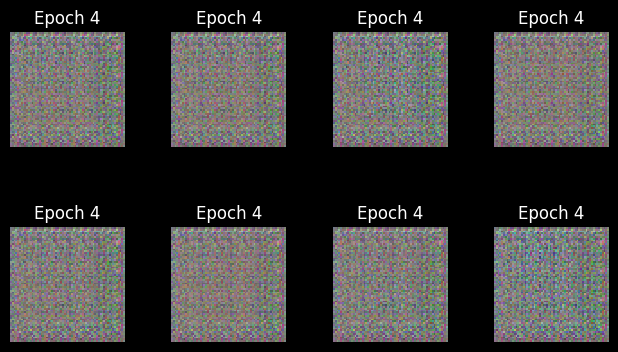

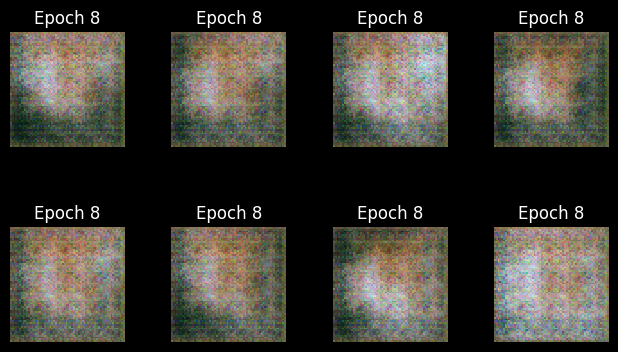

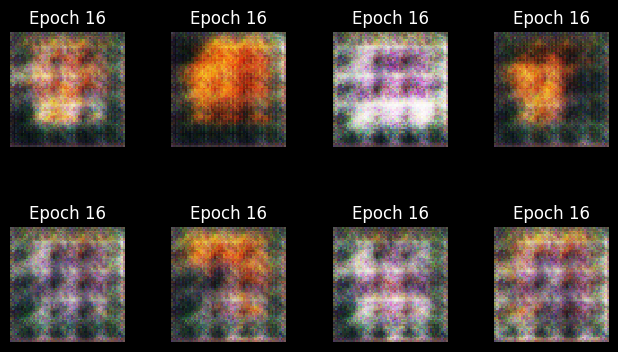

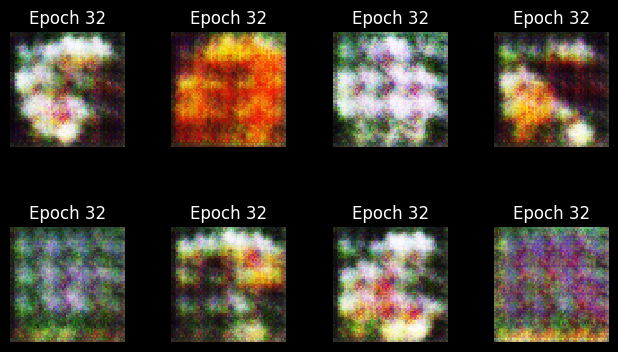

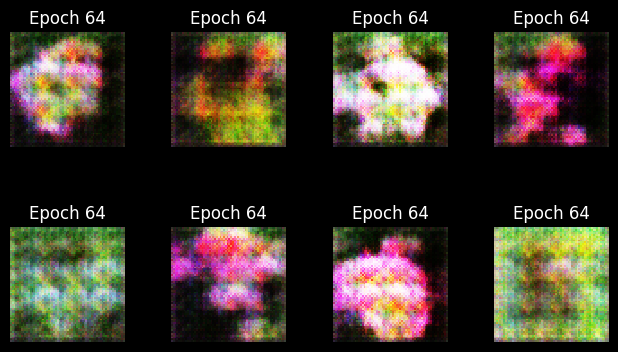

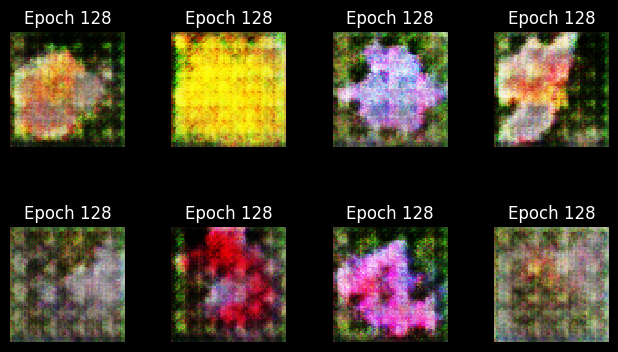

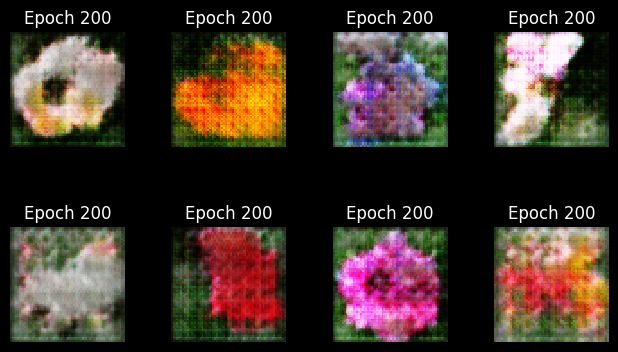

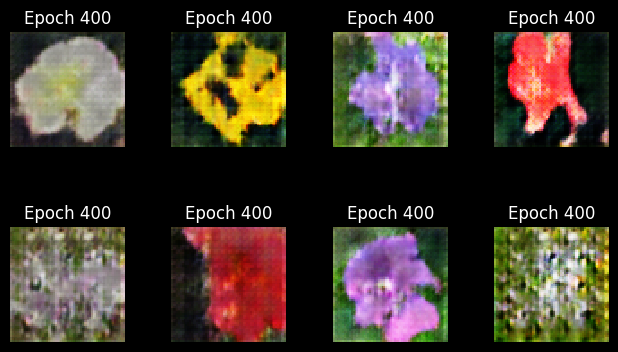

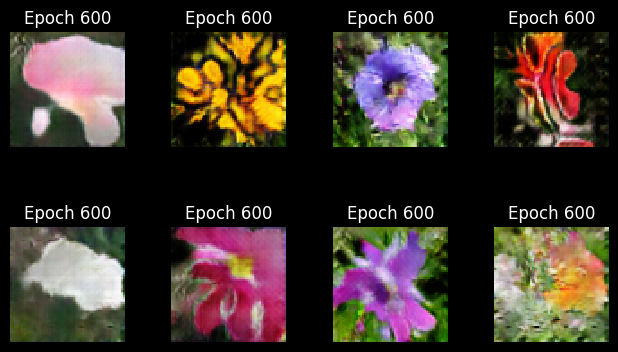

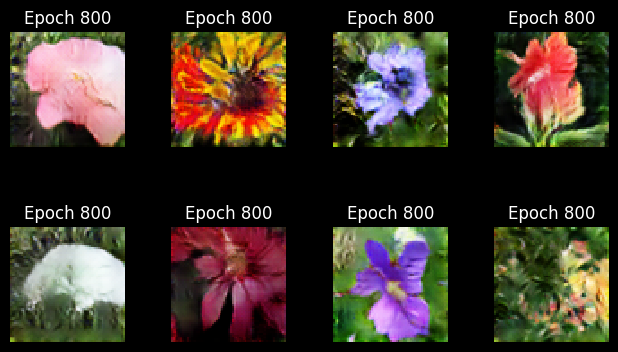

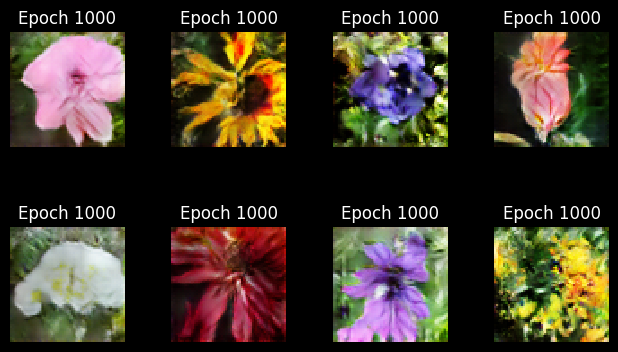

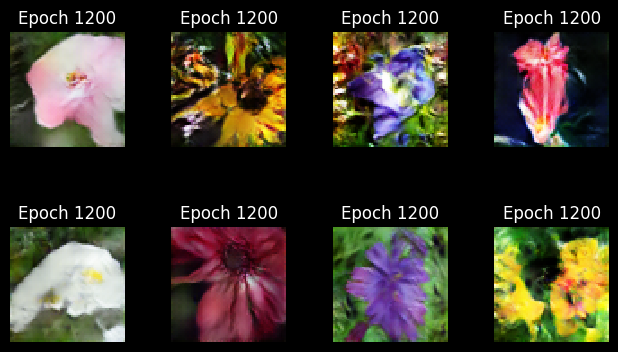

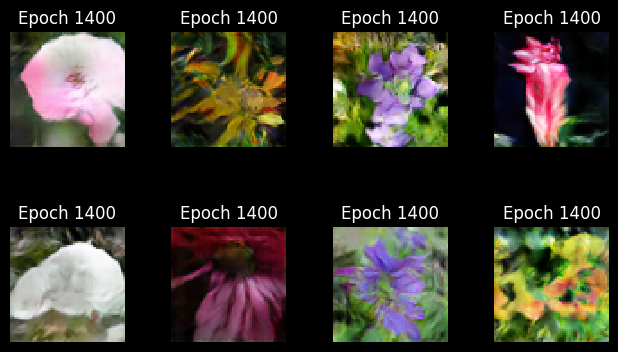

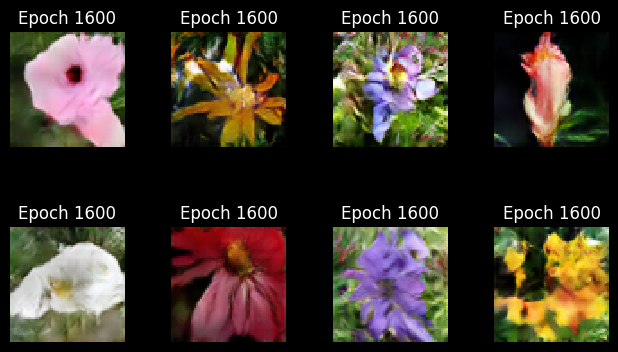

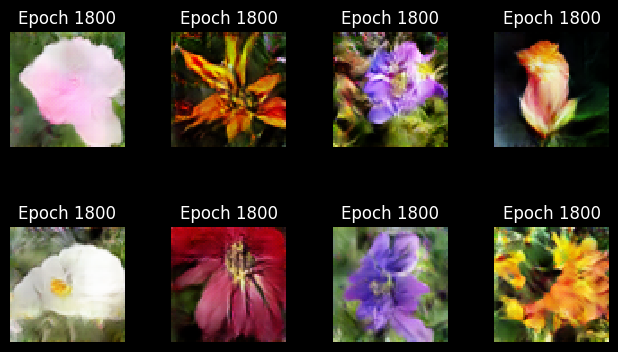

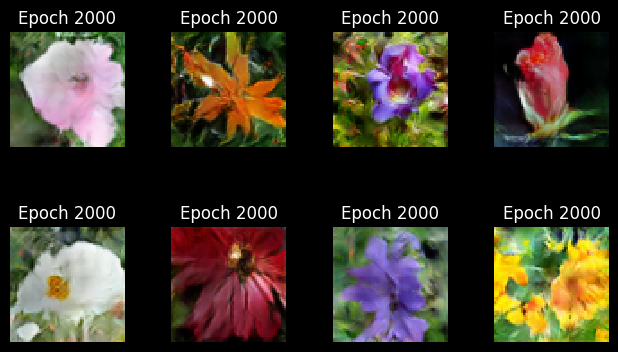

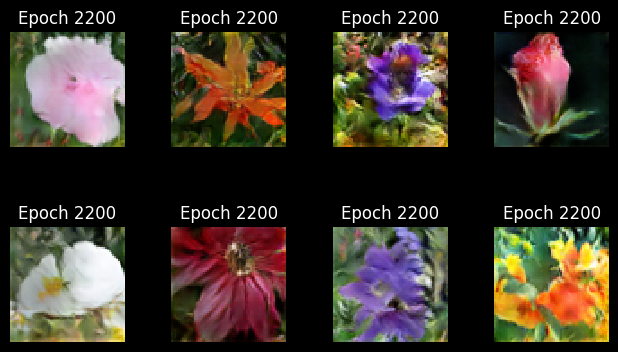

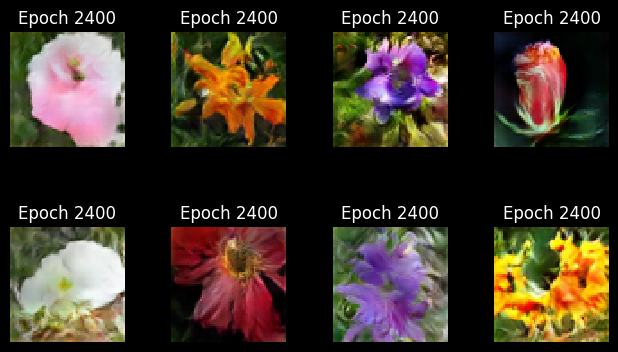

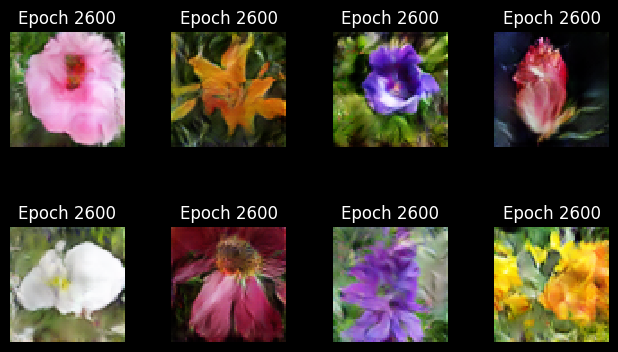

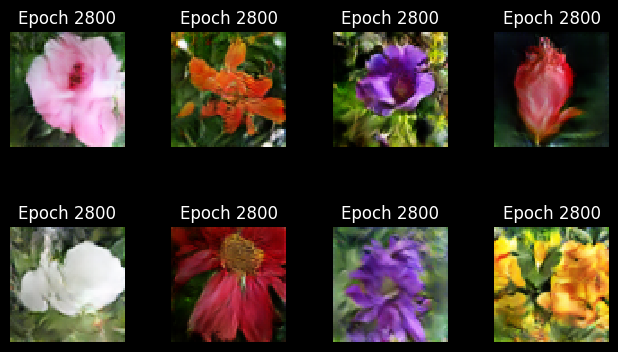

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3000` reached.


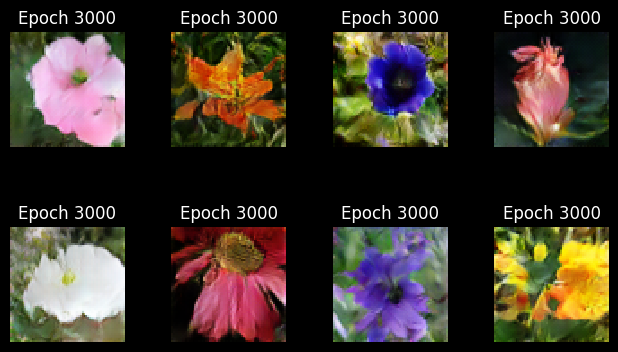

In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath="./checkpoints",
    filename="gan-{epoch:02d}-{g_loss:.2f}",
    monitor="g_loss",
    save_top_k=3,
    mode="min"
)

trainer = pl.Trainer(
    max_epochs=3000,
    devices=AVAIL_GPUS,
    callbacks=[checkpoint_callback]
)
trainer.fit(model, dm)
model.plot_imgs(show=True)

In [ ]:
# Save the final trained model
# Option 1: Save using PyTorch Lightning's save method (recommended)
model_path = './gan_flowers_final.ckpt'
trainer.save_checkpoint(model_path)
print(f"Model saved to {model_path}")

# Option 2: Save just the state dict (lighter weight, but need model class to load)
torch.save(model.state_dict(), './gan_flowers_state_dict.pth')
print("State dict saved to ./gan_flowers_state_dict.pth")

# Option 3: Save the entire model (includes architecture)
torch.save(model, './gan_flowers_complete.pth')
print("Complete model saved to ./gan_flowers_complete.pth")

INFO:pytorch_lightning.trainer.connectors.checkpoint_connector:`weights_only` was not set, defaulting to `False`.


Model saved to ./gan_flowers_final.ckpt
State dict saved to ./gan_flowers_state_dict.pth
Complete model saved to ./gan_flowers_complete.pth


In [ ]:
# Example: Compute FID score for a trained model
# Uncomment and run after training to evaluate your model

model.eval()
test_dataloader = dm.test_dataloader()
fid_score = compute_fid_score(model, test_dataloader, n_samples=5000, device='cuda')
print(f"FID Score: {fid_score:.2f}")

Computing FID...


Processing:  80%|████████  | 78/97 [00:05<00:01, 13.74it/s]


FID Score: 53.53


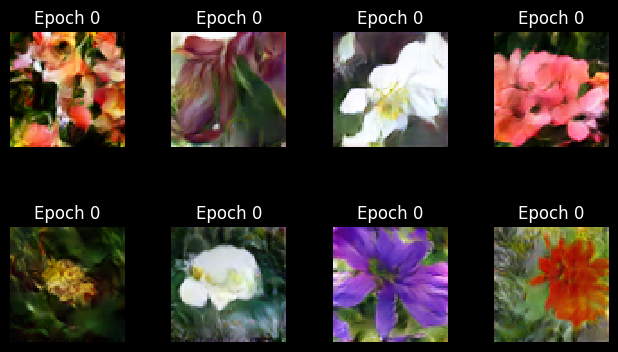

In [ ]:
model = GAN.load_from_checkpoint('./gan_flowers_final.ckpt')
model.plot_imgs()